In [4]:
import pandas as pd
import plotly as px
import matplotlib.pyplot as plt

### Explain briefly the classification you tackle, the random classifier performance and the state-of-the-art for this task


Our dataset is MultiEURLEX https://huggingface.co/datasets/multi_eurlex 


MultiEURLEX comprises 65k EU laws in 23 official EU languages. Each EU law has been annotated with EUROVOC concepts (labels) by the Publication Office of EU. Each EUROVOC label ID is associated with a label descriptor, e.g., [60, agri-foodstuffs], [6006, plant product], [1115, fruit]. The descriptors are also available in the 23 languages. Chalkidis et al. (2019) published a monolingual (English) version of this dataset, called EUR-LEX, comprising 57k EU laws with the originally assigned gold labels.


Our task is to conduct multilable multi-class classification. In addition we have choosen 3 languages English, Spanish and French out of 23 to train models on differnet languages and compare performance across them

We have 21 different labels as our target variable and in case our data was perfectly balanced Random Classifier had 1/21 or around 4.76% of accuracy if we predict all of them as one specific class. However, we have imbalance and highest and also our taks is to predict multiple lables for the same document 

We have found this [article](https://www.researchgate.net/publication/357123329_MultiEURLEX_-_A_multi-lingual_and_multi-label_legal_document_classification_dataset_for_zero-shot_cross-lingual_transfer) which may be considered SOA models and they have used mRP(mean relevance precision)to evaulate performance of their models for langauges it was in the range of 60-70%, in some case they have fine-tuned and approched to 80%

#### The choice of the metrics to evaluate the models


For our use case we have choosen F1 score as the metric to evaluate different models. F1 is basically the harmonice mean of Precision and Recall and thus we account for both. Accuracy although tempting to be used cannot provide full picture of the model performance as we have multilable clasification and let's say just one category was misclassified however whole record will be considered wrong prediction. Thus will not capture the performance of the model on the categories it has correctly picked up which will make impression that model has very low performance.

## A clear datasets split and descriptive statistics of the sets. Train / development and test sets


In [8]:
from datasets import load_dataset

dataset_fr = load_dataset('multi_eurlex', 'en')
dataset_es = load_dataset('multi_eurlex', 'es')
dataset_en = load_dataset('multi_eurlex', 'fr')

Reusing dataset multi_eurlex (/home/davo/.cache/huggingface/datasets/multi_eurlex/en/1.0.0/8ec8b79877a517369a143ead6679d1788d13e51cf641ed29772f4449e8364fb6)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset multi_eurlex (/home/davo/.cache/huggingface/datasets/multi_eurlex/es/1.0.0/8ec8b79877a517369a143ead6679d1788d13e51cf641ed29772f4449e8364fb6)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset multi_eurlex (/home/davo/.cache/huggingface/datasets/multi_eurlex/fr/1.0.0/8ec8b79877a517369a143ead6679d1788d13e51cf641ed29772f4449e8364fb6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
dataset_fr['train'].num_rows

55000

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["Train", "Test", "Validation"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[dataset_en['train'].num_rows, dataset_en['test'].num_rows, dataset_en['validation'].num_rows], name="English"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[dataset_es['train'].num_rows, dataset_es['test'].num_rows, dataset_es['validation'].num_rows], name="Spanish"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=[dataset_fr['train'].num_rows, dataset_fr['test'].num_rows, dataset_fr['validation'].num_rows], name="French"),
              1, 3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Dataset Train Test Validation Proportions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='English', x=0.1, y=0.5, font_size=20, showarrow=False),
                 dict(text='Spanish', x=0.5, y=0.5, font_size=20, showarrow=False),
                 dict(text='French', x=0.9, y=0.5, font_size=20, showarrow=False)])
fig.show()

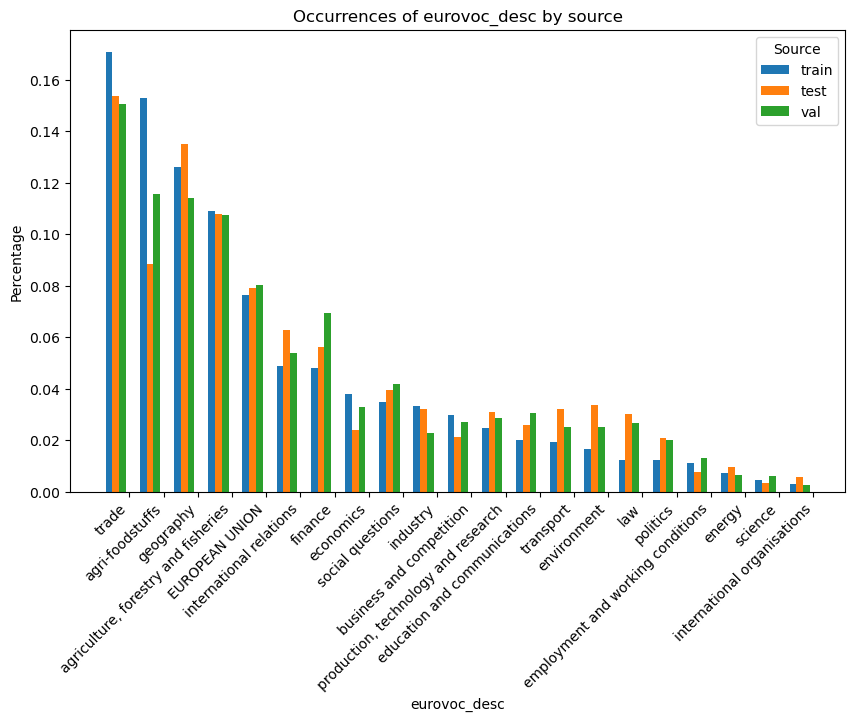

#### Preprocessing

We performed the following preprocessing. You can see details about how our preprocessing works by looking at the nlp_preproc_functions.py library. Our processing includes the following:

- Cleaning labels (Currently has lots of inconsistent formatting, such as extra spaces and commas)
- Creating a feature "pub_date" by extracting the first mentioned date in the document, and saving it as a `pd.datetime` object
    - Some of these dates are inaccurate or incomplete. If so, we're imputing them as the median date for the whole data set
- Preprocessing the documents by:
    - Making all words lower case
    - Removing punctuation
    - Tokenizing
    - Removing stopwords
        - We're also adding words that are in >=50% of documents at least once to the set of stop words
    - Stemming
    - Lemmatizing
- Binarizing the labels
- Getting the type of EU document. The raw text has titles of documents like:
    - Directive of the European Parliament and of the Council
    - Decision of the European Council
    - Regulation of the Council
- We broke this into two categories, WHO and WHAT, and saved them as binary variables:
    - Who:
        - Parliament
        - Council
        - Commission
    - What:
        - Directive
        - Regulation
        - Decision
    - Note: 
        - Each language was assigned the WHO and WHAT variable based on their own language.
        - Not all models used these variables due to time constraints. Future iterations of the project can be modified to include them.

#### Implementation of a baseline (ie non ML solution) + metrics on test set

Strictly speaking, the baseline for our model would be random imputation. Since our dataset has 21 binary classes to predict, the probability of imputing document $D_i$ correctly would be $\left(\frac{1}{2}\right)^{\bar Y}$, or a near zero number. We instead decided to use a linear-based model, the logistic regression, as our baseline. 

Find the metrics below:

English metrics:

English Train f1: 0.7956

Validation f1: 0.6857

Train ROC_AUC: 0.7523794304267641

Val ROC_AUC: 0.7523794304267641

Train log_loss: 31.731818866182216

Val log_loss: 50.72586836422719

Train Recall: 0.7268860520200969

Val Recall: 0.5647900398623928

Train MSE: 0.05746147186147188

Val MSE: 0.0903047619047619

For our baseline model of a logistic regression, the accuracy was higher than we expected but still lower than both RNN and BERT models on all metrics. Particularly the log_loss. 

### Implementation of a RNN solution + metrics on test set


We evaluated on our test data after running the model on the validation. This is our output.</br>

### English
{'Test-loss': 0.23539113998413086,</br>
 'Test-f1': 0.6825497265485002,</br>
 'Test-roc_auc': 0.7018134586151967,</br>
 'Test-accuracy': 0.9257572293281555,</br>
 'Test-recall': 0.6194557293115922,</br>
 'epoch': 20.0}</br>
 
### Spanish
{'Test loss': 0.23667499423027039,</br>
'Test accuracy': 0.9255258440971375, </br>
'Test ROC AUC score': 0.6895668837640723, </br>
'Test precision': 0.765416358895643, </br>
'Test recall': 0.6214035282987367, </br>
'Test F1 score': 0.6636215137018721,</br>
'epoch': 20.0}</br>

### French
{'Test loss': 0.23539113998413086, </br>
'Test accuracy': 0.9257572293281555, </br>
'Test ROC AUC score': 0.7018134586151967, </br>
'Test precision': 0.8006338596476694, </br>
'Test recall': 0.6194557293115922, </br>
'Test F1 score': 0.6825497265485002,</br>
'epoch': 20.0}</br>

## Improvements
To enhance the overall performance, we could consider several strategies:

Train the model on a balanced dataset. </br>
Increase the amount of data and epochs (especially the epochs as we did not do enough training and can expect serious improvements). </br>
Apply additional regularization techniques like dropout.</br>
Implement ensemble modifications to the model.

## Biases
What are potential biases of our model? Some ideas we had were:

If we had enough time to do a trend then we would notice that countries with large entries get better predictions. </br>
Due to the size of the tokenizers in English which jhave been fine-tuned on English corpus, the peformance will higher than others with less tokenizers.

### Implementation of a BERT model + metrics on test set


#### A few examples with their predicted outputs for each of the three implementations


## Non-ML

## RNN

### Bert

### Below you can observe Bert model predicted examples for 3 languages. Based on examples above it is clear that BERT model learned to pick up majority of the categories but very often missed one category from the true category list. Good part Bert picks up majority of the classes, bad it often misses one class

### Error Analysis of the models: where did it learn well / bad ?


### Bert

Based on examples above it is clear thta BERT model learned to pick up majority of the categories but very often missed one category from the true category list. Good part Bert picks up majority of the classes, bad it often misses one class

#### Comment the metrics: can you explain the metrics difference between implementations? Where do you stand regarding SOA/random classifier?


## Bert

## Biases: Try to identify any type of bias in the models


## Bert

Biasses of Bert model can be that it will have higher performance on English data as more tokeniziers have been fine tuned on English corpus. Generally for this data some categories of target variable like trade agrifoods-stuff have higher proportion of observation hence they would have higher probbility of appearing as suggested label

### Improve your BERT solution depending on error analysis, biases or other analysis you think is relevant


To improve Bert model for Frech language which has lower performance metrics compared to English and Spanish Bert models we will tokenizers specifically fine tuned on Fench language as previously we have used bert-base-multilingual-uncased. With using this approach it is highly likely we get higher performance

### Next steps: What are the main limitations of your models? What would be the next steps to improve it?

## Bert

Next steps can be to collect and lable more data, use different Bert models like DistillBert, Roberta , use more specific tokenizers and fine-tune hyperparameters for highest performance